# Model selection

In [2]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

We'll use the same dataset as [before](./1-variables).

In [3]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata

When we say that a model is statistically significant, what we actually mean is that one model is much more likely to be true than another _simpler_ model. In classical statistical testing these two models are called the alternative hypothesis and the null hypothesis.

While statistical testing is powerful for some models, it often falls short when we try to do anything more complex. If we for example include any cellular latent variables, it becomes impossible to calculate any reasonable p-value. Furthermore, if we want to compare many different models.

One main reason to thus use probabilistic modelling is that it allows us to generalize statistical testing to a technique called model selection. In this way, we can even In a probabilistic setting, the generalization of statistical testing is called model selection.

## Creating the models

We will illustrate model selection with perhaps the simplest model possible: differential expression. We are given an outcome, the overexpression of Myod1, and now want to know which genes are differential. To do this, we will create 3 models: a linear response, a non-linear spline response, and a constant response.

At this stage, the following model-building sections should not hold any mysteries for you and are undocumented. Feel free to try out any extra models, e.g. a {class}`latenta.links.scalar.Switch`, or play with some of the parameters of the spline function to see how this affects the outcome.

In [4]:
models = {}

In [5]:
overexpression = la.Fixed(adata.obs["log_overexpression"], label="overexpression")

### Model 1: Linear

In [6]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Linear(overexpression, a = True, definition=foldchange.value_definition)
foldchange.plot()

  0%|                                                                                                         …

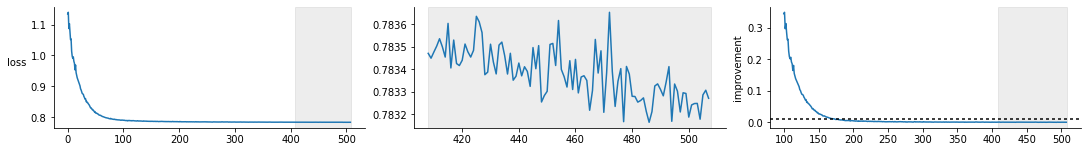

In [7]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot();

In [8]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome, interpretable = transcriptome.p.mu.expression, observed = overexpression_observed
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

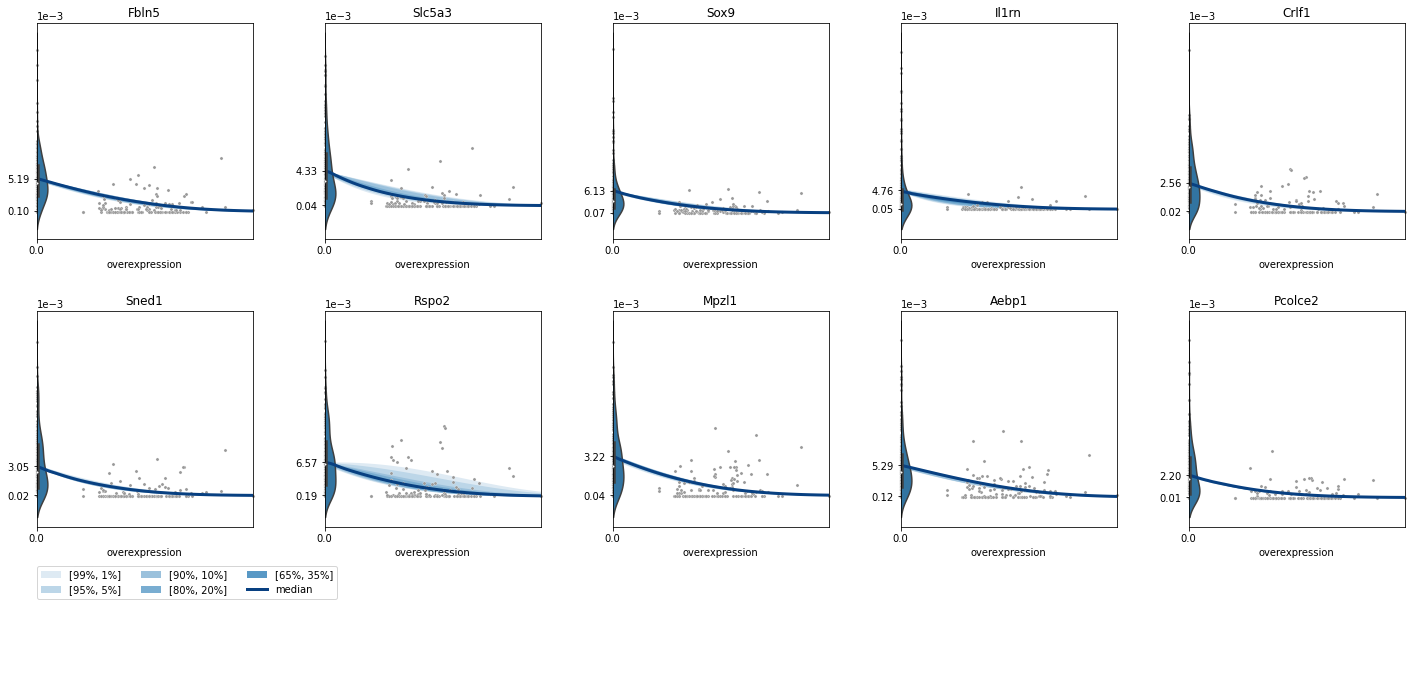

In [11]:
overexpression_causal.plot_features();

In [12]:
models["linear"] = {
    "root":transcriptome,
    "overexpression_causal":overexpression_causal,
    "transcriptome_observed":transcriptome_observed
}

### Model 2: Spline

In [13]:
overexpression = overexpression.reset().clone()

In [14]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Spline(overexpression, definition=foldchange.value_definition)
foldchange.plot()

  0%|                                                                                                         …

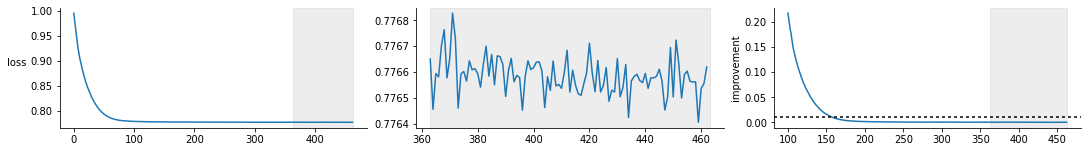

In [15]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot();

In [16]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome, interpretable = transcriptome.p.mu.expression, observed = overexpression_observed
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

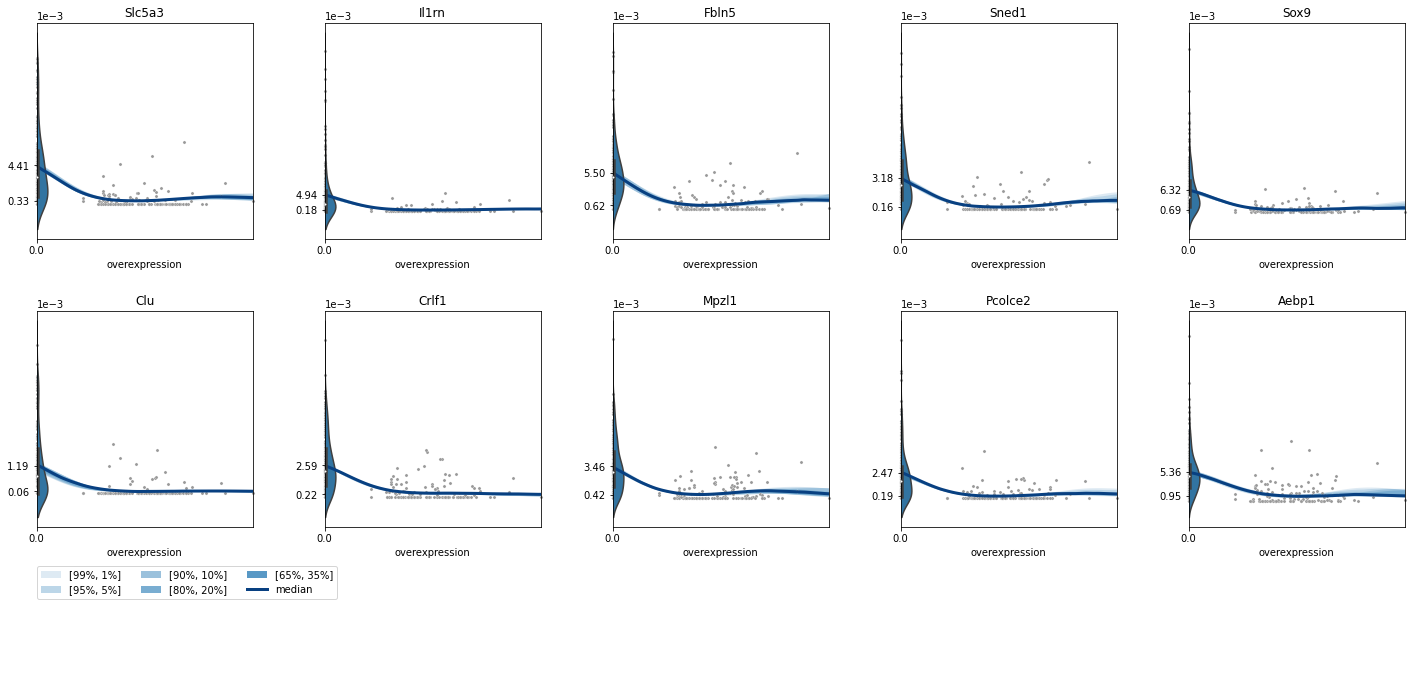

In [19]:
overexpression_causal.plot_features();

In [20]:
models["spline"] = {
    "root":transcriptome,
    "overexpression_causal":overexpression_causal,
    "transcriptome_observed":transcriptome_observed
}

### Model 3: Constant

In [48]:
overexpression = overexpression.reset().clone()

In [49]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata)
foldchange = transcriptome.find("foldchange")

foldchange.overexpression = la.links.scalar.Constant(overexpression,definition=foldchange.value_definition)
foldchange.plot()

  0%|                                                                                                         …

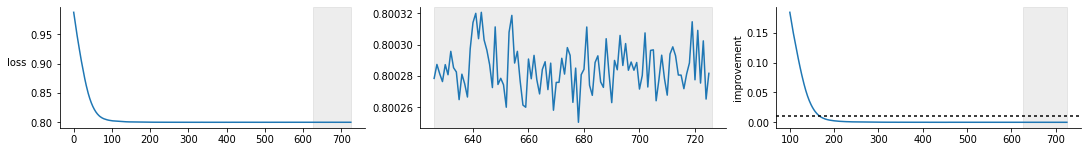

In [50]:
with transcriptome.switch(la.config.device):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot();

In [51]:
transcriptome_observed = la.posterior.vector.VectorObserved(transcriptome)
transcriptome_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
overexpression_observed.sample(5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
    overexpression, transcriptome, interpretable = transcriptome.p.mu.expression, observed = overexpression_observed
)
overexpression_causal.sample(10)
overexpression_causal.sample_random(10)
overexpression_causal.observed
overexpression_causal.sample_empirical()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

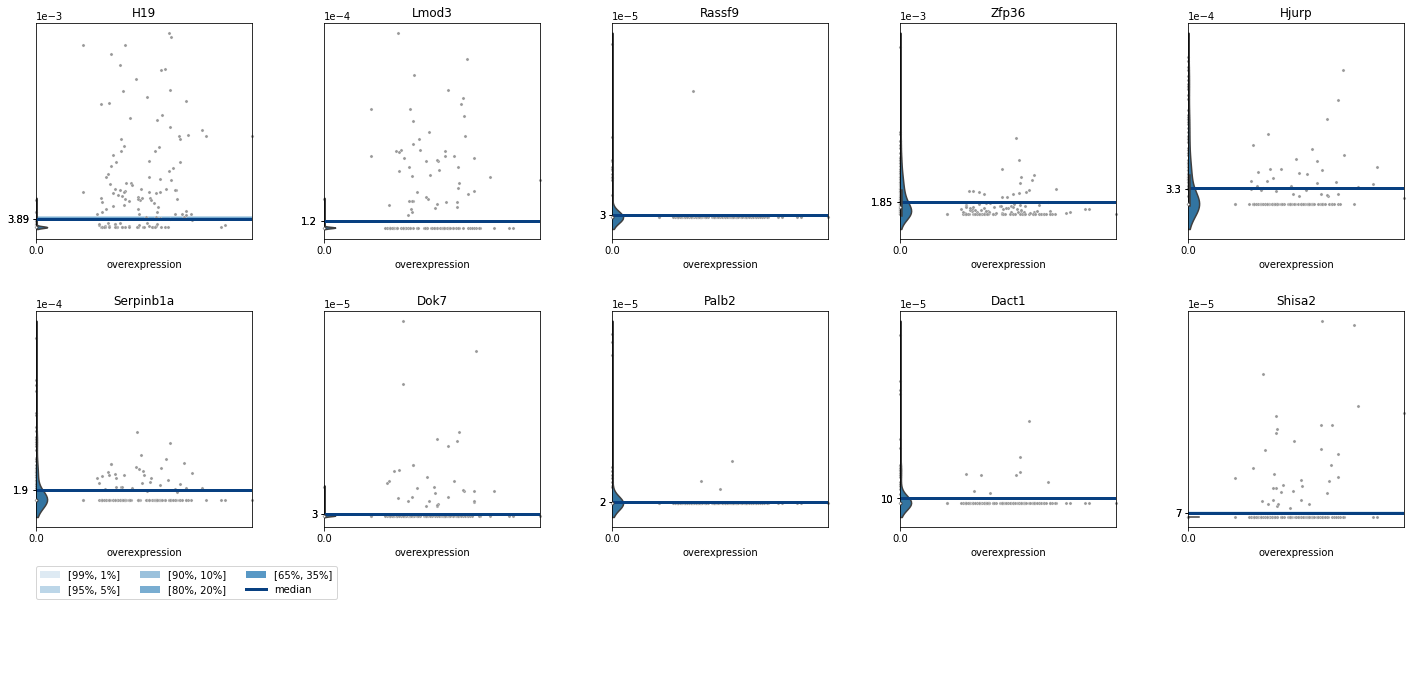

In [54]:
overexpression_causal.plot_features();

In [55]:
models["constant"] = {
    "root":transcriptome,
    "overexpression_causal":overexpression_causal,
    "transcriptome_observed":transcriptome_observed
}

## Model selection

In [48]:
import pandas as pd

In [49]:
model_ids = list(models.keys())

In [50]:
elbo_genes = pd.DataFrame({model_id:model["transcriptome_observed"].elbo_features.to_pandas() for model_id, model in models.items()})
likelihood_genes = pd.DataFrame({model_id:model["transcriptome_observed"].elbo_features.to_pandas() for model_id, model in models.items()})

In [51]:
elbo_genes

,linear,spline,constant
gene,,,
ENSMUSG00000000031,-1024.826813,-1005.384348,-1102.371604
ENSMUSG00000000058,-983.190058,-979.222342,-996.791768
ENSMUSG00000000078,-1756.658016,-1755.083106,-1786.357388
ENSMUSG00000000184,-1713.830251,-1708.132142,-1719.405142
ENSMUSG00000000202,-188.151099,-175.847121,-229.556925
...,...,...,...
ENSMUSG00000117278,-142.960889,-144.050767,-143.241970
ENSMUSG00000117515,-245.284422,-247.184186,-244.611311
ENSMUSG00000117710,-107.012867,-108.967285,-109.558836


### Comparing constant versus all other models

First, we can find generally differentially expressed genes by simply comparing the constant model with all other models:

In [55]:
bfs = (elbo_genes.drop(columns = "constant") - elbo_genes["constant"].values[:, None])
scores = bfs.max(1).rename("bf").to_frame()

<AxesSubplot:ylabel='Density'>

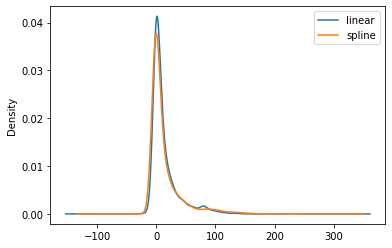

In [72]:
bfs.plot(kind = "kde")

In [56]:
scores["symbol"] = adata.var["symbol"][scores.index]
scores = scores.sort_values("bf", ascending = False)
scores

,bf,symbol
gene,,
ENSMUSG00000037062,232.657103,Sh3glb1
ENSMUSG00000028464,230.256808,Tpm2
ENSMUSG00000091898,178.234226,Tnnc1
ENSMUSG00000026459,174.003026,Myog
ENSMUSG00000061723,157.078036,Tnnt3
...,...,...
ENSMUSG00000060860,-6.643306,Ube2s
ENSMUSG00000058056,-7.003864,Palld
ENSMUSG00000030103,-7.457112,Bhlhe40


Text(0.5, 0.98, 'Non-differential genes')

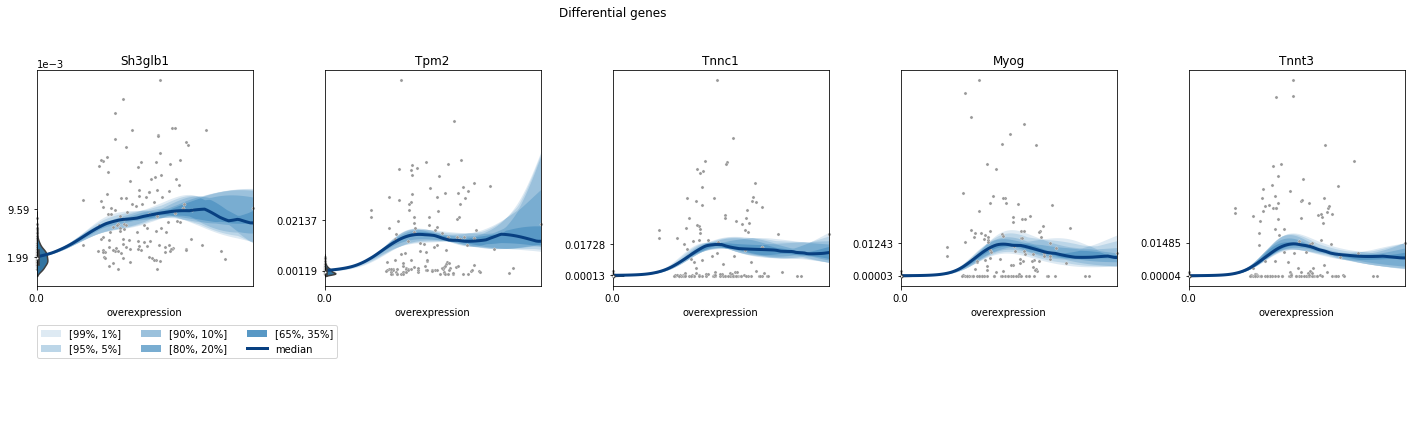

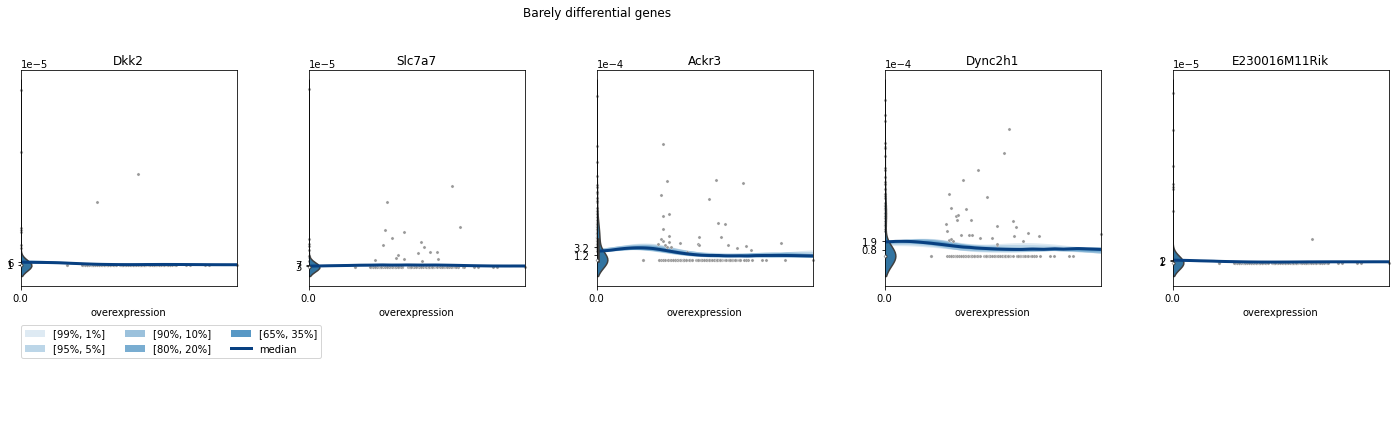

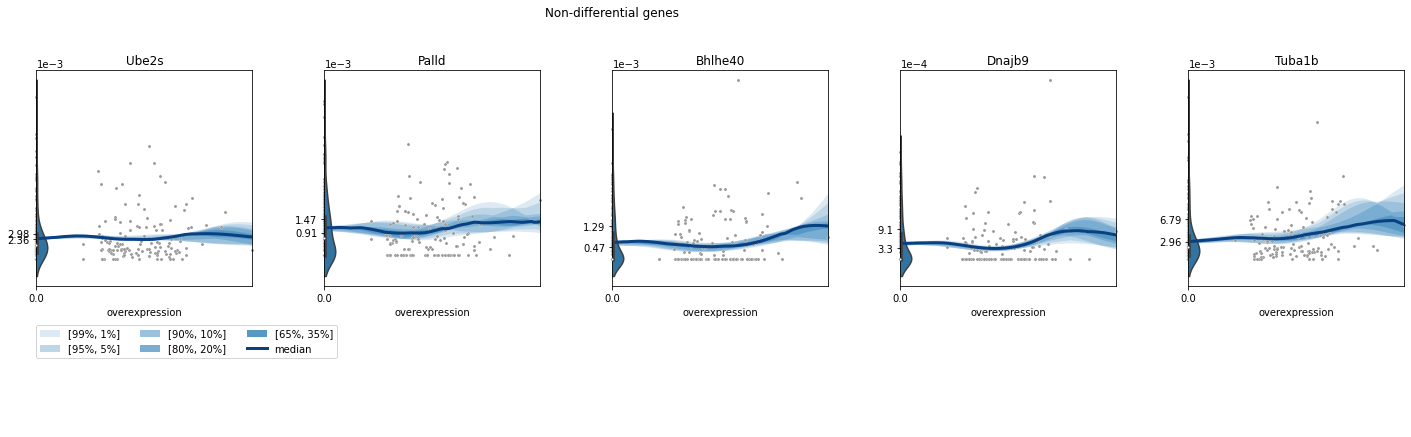

In [57]:
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = scores.index[:5]);
plot.suptitle("Differential genes")
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = scores.query("bf > log(10)").index[-5:]);
plot.suptitle("Barely differential genes")
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = scores.index[-5:]);
plot.suptitle("Non-differential genes")

:::{note}

Working with these different models and posteriors may feel quite cumbersome, with tons of repeated code for each model. We agree! That's why in the next tutorial, you're going to see our approach at making these things easier to scale up and maintaining persistence of models across session.

:::

### Comparing spline and linear

In [61]:
scores = (elbo_genes["spline"] - elbo_genes["linear"]).rename("bf").to_frame()
scores["bf_constant"] = bfs.max(1)
scores = scores.query("bf_constant > log(10)")

In [62]:
scores["symbol"] = adata.var["symbol"][scores.index]
scores = scores.sort_values("bf", ascending = False)
scores

,bf,bf_constant,symbol
gene,,,
ENSMUSG00000026459,86.539835,174.003026,Myog
ENSMUSG00000061723,84.565979,157.078036,Tnnt3
ENSMUSG00000026414,70.823109,139.767257,Tnnt2
ENSMUSG00000017300,63.893324,129.120389,Tnnc2
ENSMUSG00000031097,57.897532,140.387668,Tnni2
...,...,...,...
ENSMUSG00000030695,-9.456706,60.985146,Aldoa
ENSMUSG00000063694,-10.991136,47.043959,Cycs
ENSMUSG00000026335,-11.091818,58.368670,Pam


In [63]:
nonlinear = scores.query("(bf > log(10))").sort_values("bf_constant", ascending = False)
unclear = scores.query("(bf > log(10)) & (bf < log(30))").sort_values("bf_constant", ascending = False)
linear = scores.query("(bf < log(10))").sort_values("bf_constant", ascending = False)

Text(0.5, 0.98, 'Linear genes')

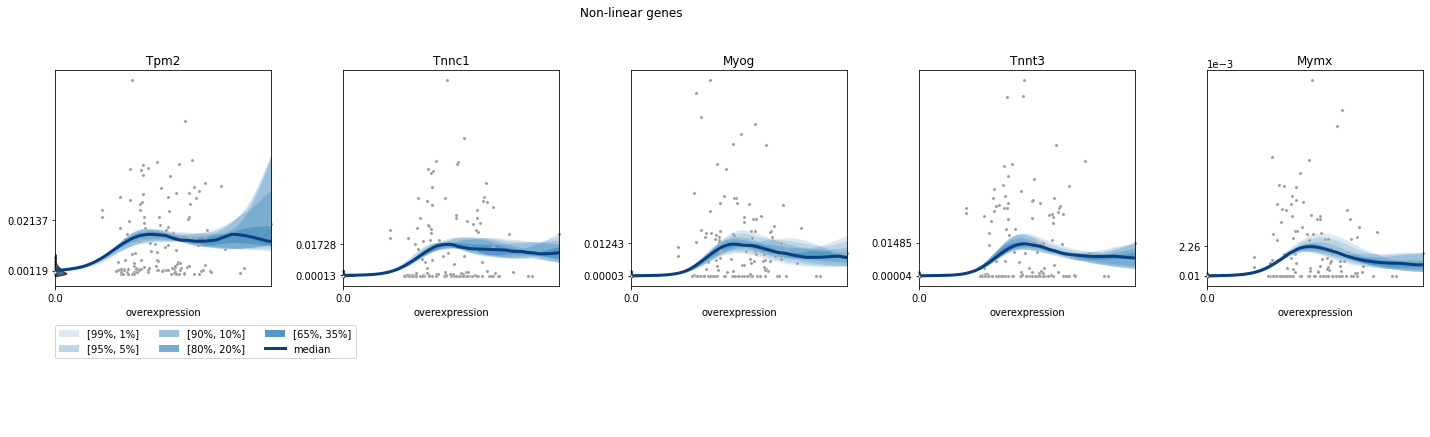

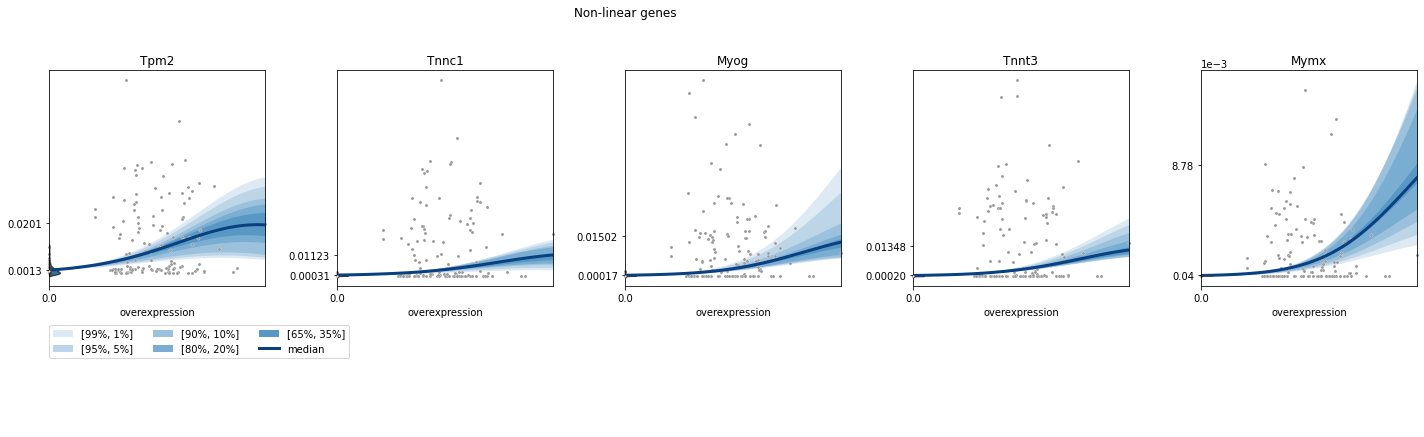

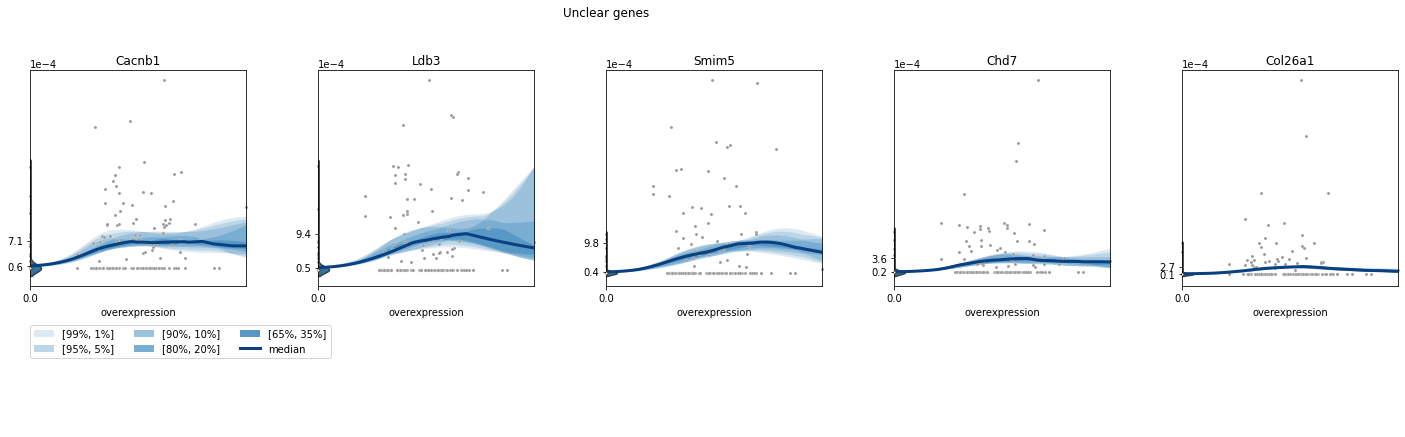

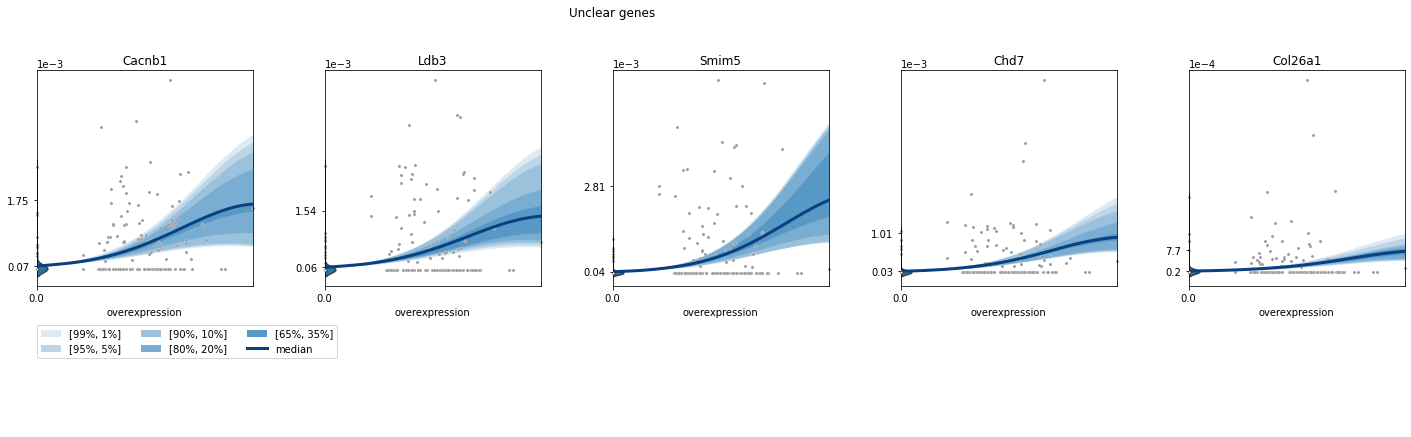

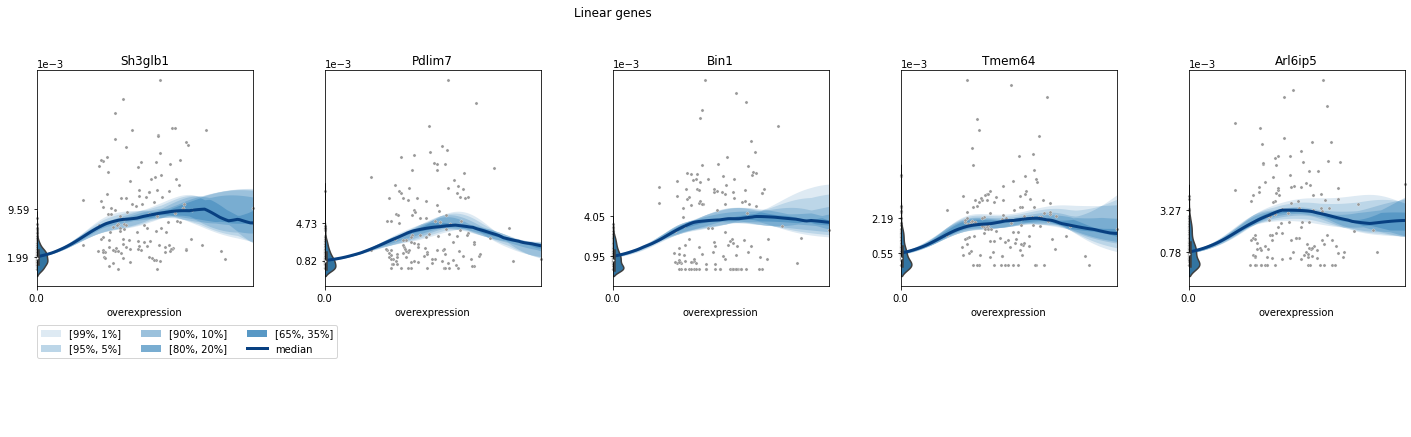

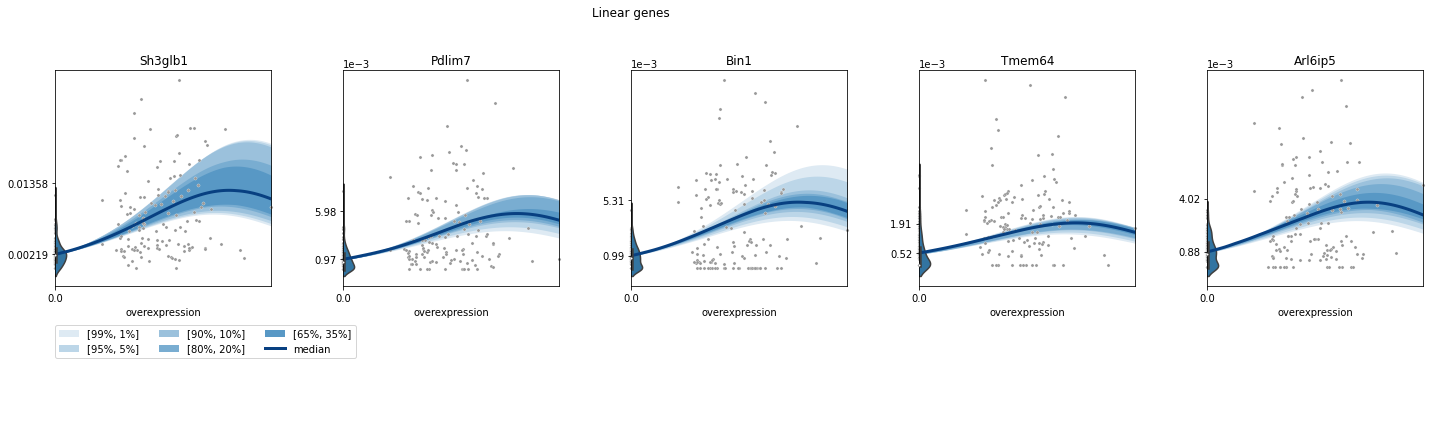

In [78]:
plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = nonlinear.index[:5]);
plot.suptitle("Non-linear genes")
plot = models["linear"]["overexpression_causal"].plot_features(feature_ids = nonlinear.index[:5]);
plot.suptitle("Non-linear genes")

plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = unclear.index[:5]);
plot.suptitle("Unclear genes")
plot = models["linear"]["overexpression_causal"].plot_features(feature_ids = unclear.index[:5]);
plot.suptitle("Unclear genes")


plot = models["spline"]["overexpression_causal"].plot_features(feature_ids = linear.index[:5]);
plot.suptitle("Linear genes")
plot = models["linear"]["overexpression_causal"].plot_features(feature_ids = linear.index[:5]);
plot.suptitle("Linear genes")